#Installing Dependencies and Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ColabData

/content/drive/MyDrive/ColabData


In [3]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import keras
# Deep learning libraries
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Explore Data Analysis

In [ ]:
path_normal = "/content/drive/MyDrive/ColabData/COVID-19_Radiography_Dataset/Dataset/Normal/images"
path_covid = "/content/drive/MyDrive/ColabData/COVID-19_Radiography_Dataset/Dataset/COVID/images"

len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))

In [ ]:
print(len_normal)
print(len_covid)

[0 1]


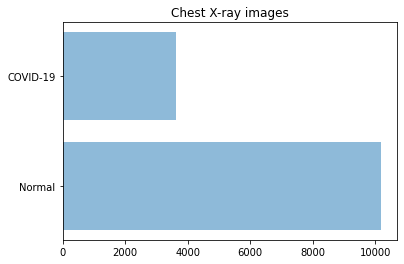

In [ ]:
classes = ('Normal', 'COVID-19')
y_pos = np.arange(len(classes))
print(y_pos)
performance = [len_normal, len_covid]

plt.barh(y_pos,performance, align='center', alpha=0.5)
plt.yticks(y_pos, classes)
plt.title('Chest X-ray images')

plt.show()

**Overview Chest X-ray images**

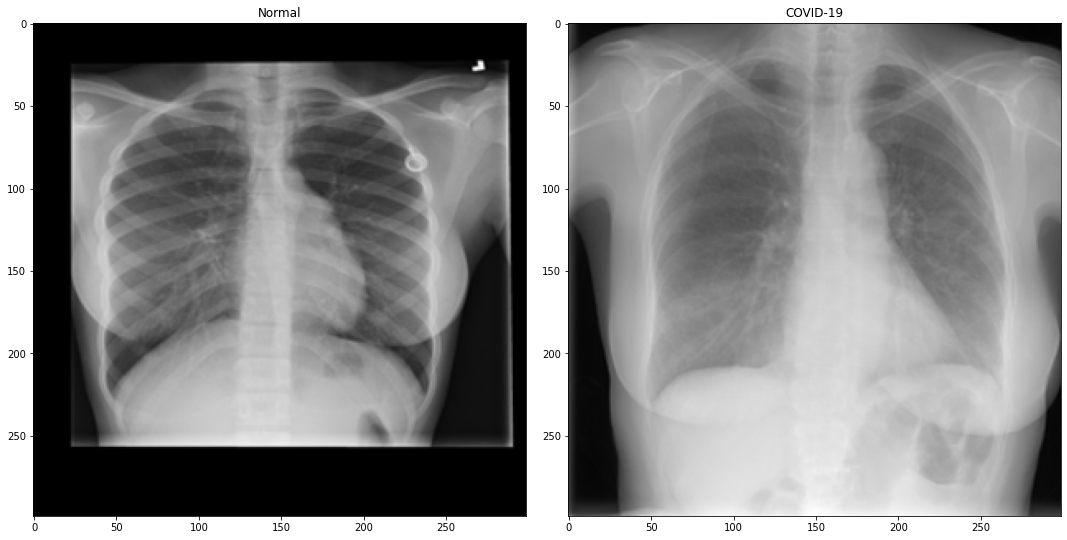

In [ ]:
labels = ['Normal', 'COVID-19']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1994.png"

imgs = [img1, img2]

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,2):

    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

**Load data**

In [ ]:
from keras import preprocessing
from skimage.transform import resize

def resize_image(imgpath):
    img = tf.keras.preprocessing.image.load_img(imgpath)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = resize(img, (224,224), anti_aliasing=True)
    return img

In [ ]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except:
        None
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except:
        None
        
x_ = np.array(x_)

In [ ]:
print(x_.shape)

(13822, 224, 224, 3)


**Model Clases**

# Split test, train, validation data

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.15,random_state = 40)

**Clases: Normal, COVID-19, Lung Opacity, Viral pneumonia**

In [ ]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y,num_classes = 2)

classNames = ["Normal","COVID_19"]
print(classNames)

['Normal', 'COVID_19']


In [4]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Conv2D,Input,GlobalAveragePooling2D
from tensorflow.keras import layers  
from tensorflow.keras.applications import VGG16

In [11]:
def build_model():
    # use imagenet - pre-trainined weights for images
    baseModel = VGG16(weights= 'imagenet', include_top = False, input_shape=(224, 224, 3))

    for layer in baseModel.layers[:-3]:
      layer.trainable = False

    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    optimizers = RMSprop(learning_rate=0.00001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

    return model
model=build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#Building the Resnet 152 Model

In [ ]:
IMAGE_SHAPE= (224,224)
BATCH_SIZE= 32

In [ ]:
#Let's compare the following two models
resnet_50_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# lets make a create_model() function to create a model from URL
def create_model(model_url, num_classes=2):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential Model with it.

  Args:
    model_url (str): A tensorflow hub feature extractor URL.
    num_classes (int): Number of output nequrons in the output layer, should be equal to number of target classes, default 2.

  Returns:
    An uncompiled Keras sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  #Download the pre-trained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=True, #Freeze the already learned patterns
                                         name="feature_extractor_layer",
                                         input_shape=IMAGE_SHAPE+(3,)) 

  #Create our own model 
  model = tf.keras.Sequential([feature_extractor_layer,
                             layers.Dense(1, activation="sigmoid", name="output_layer")
                             ])
  return model

In [ ]:
#create resnet model
resnet_50_model = create_model(resnet_50_url)

In [ ]:
#Compile our resnet model
resnet_50_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
y_train, y_val = np.array(y_train), np.array(y_val)
print(y_train)
print(y_val)

[1 0 1 ... 1 0 0]
[1 0 0 ... 0 0 0]


In [ ]:
# Lets fit the model to our data
history = resnet_50_model.fit(x_train, y_train,
                                  epochs=20,
                                  validation_data=(x_val, y_val), batch_size=32)

Epoch 1/20
294/294 [==============================] - ETA: 0s - loss: 0.4740 - accuracy: 0.9338

# Test and Evaluate Model

**Predict with test data**

In [ ]:
y_test=np.array(y_test)
print(y_test)

In [ ]:
# Get predictions
mypredict = model.predict(x_test)


In [ ]:
pred_labels= list()

for label in mypredict:
  rounded_labels=np.round_(label)
  rounded_labels=rounded_labels.astype(int)
  pred_labels.append(rounded_labels[0])
pred_labels=np.array(pred_labels)
print(pred_labels)

In [ ]:
evaluate = model.evaluate(x_test, y_test)

In [ ]:
print("Accuracy: {:.2f}%".format(evaluate[1] * 100))  
print("Loss: {}".format(evaluate[0])) 

# Confusion matrix

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. The confusion matrix shows the ways in which your classification model is confused when it makes predictions. It gives us insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

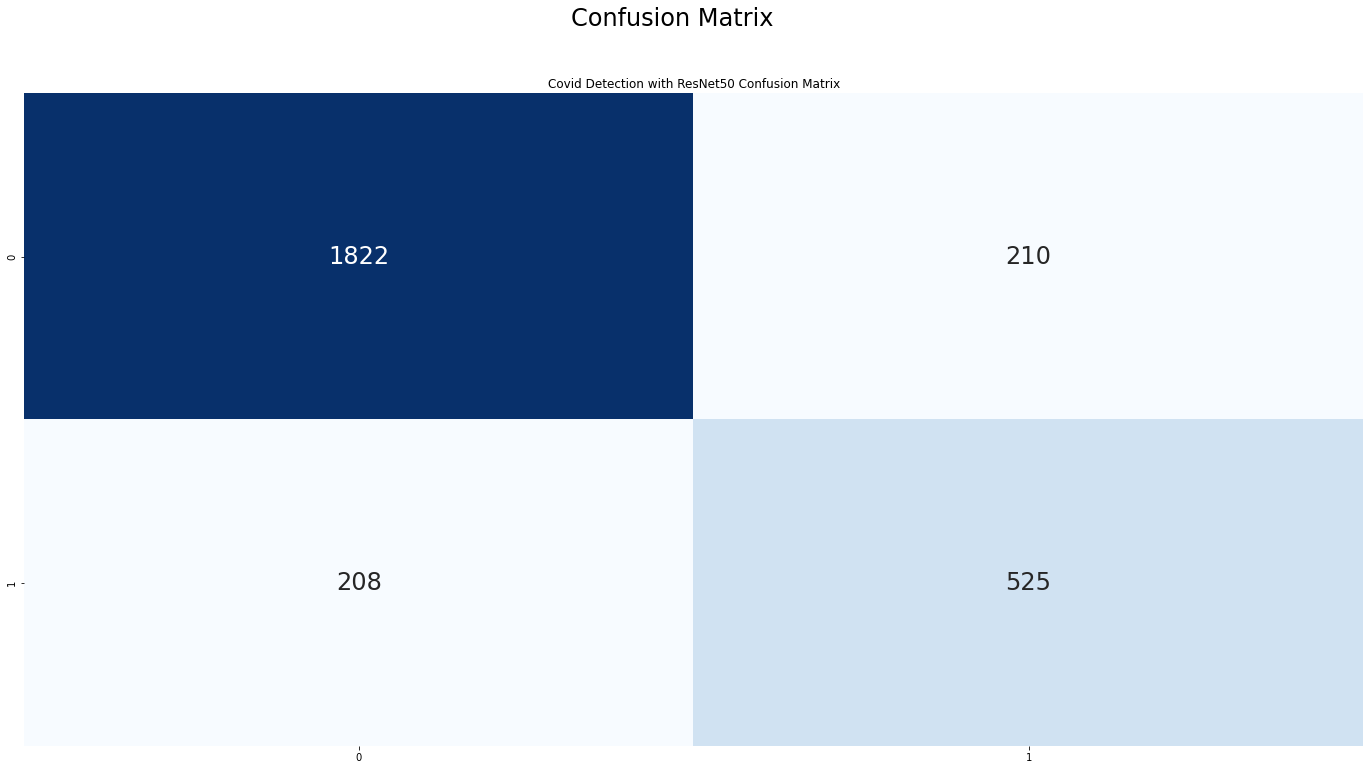

In [ ]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrix",fontsize=24)
plt.title("Covid Detection with ResNet50 Confusion Matrix")
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()



In [ ]:
print ('Accuracy Score :',accuracy_score(y_test, pred_labels ))
print ('Report : ')
print (classification_report(y_test, pred_labels ))

Accuracy Score : 0.8488245931283906
Report : 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2032
           1       0.71      0.72      0.72       733

    accuracy                           0.85      2765
   macro avg       0.81      0.81      0.81      2765
weighted avg       0.85      0.85      0.85      2765



#Graph of Loss Functions etc.

In [ ]:
import matplotlib.pyplot as plt

#Plot the validation and training curves

def plot_loss_curves(history):
  """
  Returns saperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range (len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label = "validation loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot Accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "Training Accuracy")
  plt.plot (epochs, val_accuracy, label = "Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()


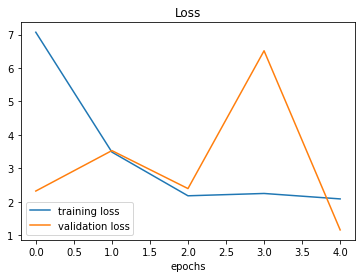

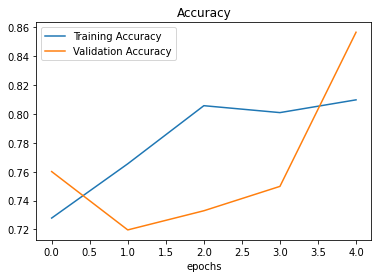

In [ ]:
plot_loss_curves(history)

#Prediction of a Single Image

In [ ]:
from numpy.core.fromnumeric import reshape
img_path='/content/Normal-4.png'
img = tf.keras.preprocessing.image.load_img(img_path)
img = tf.keras.preprocessing.image.img_to_array(img)
img = resize(img, (100,100), anti_aliasing=True)
img= img.reshape(1,100,100,3)
predict=model.predict(img)
prediction=np.round_(predict).astype(int)
predicted_class=classes[prediction[0][0]]
if prediction[0][0]==0:
  probability=1-predict[0][0]
else:
  probability=predict[0][0]
print("The predicted class is", predicted_class, "with the probability of", probability)

The predicted class is Normal with the probability of 0.9851036965847015


In [ ]:
model.save('resnet_model.h5')

**References:**

https://github.com/abhinavsagar/kaggle-notebooks/blob/master/Chest_X-Ray.ipynb
https://www.kaggle.com/code/robikscube/eda-lets-detect-pneumonia-explore-lung-images
https://www.kaggle.com/code/malekmavetgaming/diagnosing-pneumonia-with-your-convnet-ional-dr#build
https://www.sciencedirect.com/science/article/pii/S2666285X21000558                               
https://neurohive.io/en/popular-networks/vgg16/